# Ocena jakości wina Vinho Verde

Celem zadania jest ocena jakości wina.

Uwzględniono dwa zbiory danych dotyczące próbek czerwonego wina Vinho Verde z północy Portugalii.

Źródło: 
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

- 1600 obserwacji z 11 zmiennymi wejściowymi i jedną zmienną wyjściową.
- Zmienne opisują:
  1. Stałą kwasowość.
  2. Kwasowość lotną.
  3. Kwas cytrynowy.
  4. Cukier resztkowy.
  5. Chlorki.
  6. Wolny dwutlenek siarki.
  7. Całkowity dwutlenek siarki.
  8. Gęstość.
  9. pH.
  10. Siarczany.
  11. Alkohol.
  12. Jakość (ocena od 0 do 10).

[Dane](https://github.com/UEPP40/PUM/blob/c1ab27e52bc82cc151bb217b27bd25dfd057d9e8/winequality-red.csv)


# Import bibliotek, pliku csv oraz wstępny przegląd danych

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import hashlib as hl
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

In [2]:
# Wczytanie danych z pliku CSV do ramki danych
wineDataFrame = pd.read_csv('winequality-red.csv', sep=";")

# Wyświetlenie pierwszych 5 rekordów wraz z podstawowymi informacjami o danych
print("Pierwsze 5 rekordów zbioru danych:")
print(wineDataFrame.head(5))

print("\nInformacje o zbiorze danych:")
# Wyświetlenie podstawowych informacji o zbiorze danych
print(wineDataFrame.info())

print("\nStatystyki opisowe zbioru danych:")
# Wyświetlenie statystyk opisowych zbioru danych
print(wineDataFrame.describe())

Pierwsze 5 rekordów zbioru danych:
   fixed acidity  volatile acidity citric acid residual sugar chlorides  \
0            7.4              0.70           0            1.9     0.076   
1            7.8              0.88           0            2.6     0.098   
2            7.8              0.76        0.04            2.3     0.092   
3           11.2              0.28        0.56            1.9     0.075   
4            7.4              0.70           0            1.9     0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2  

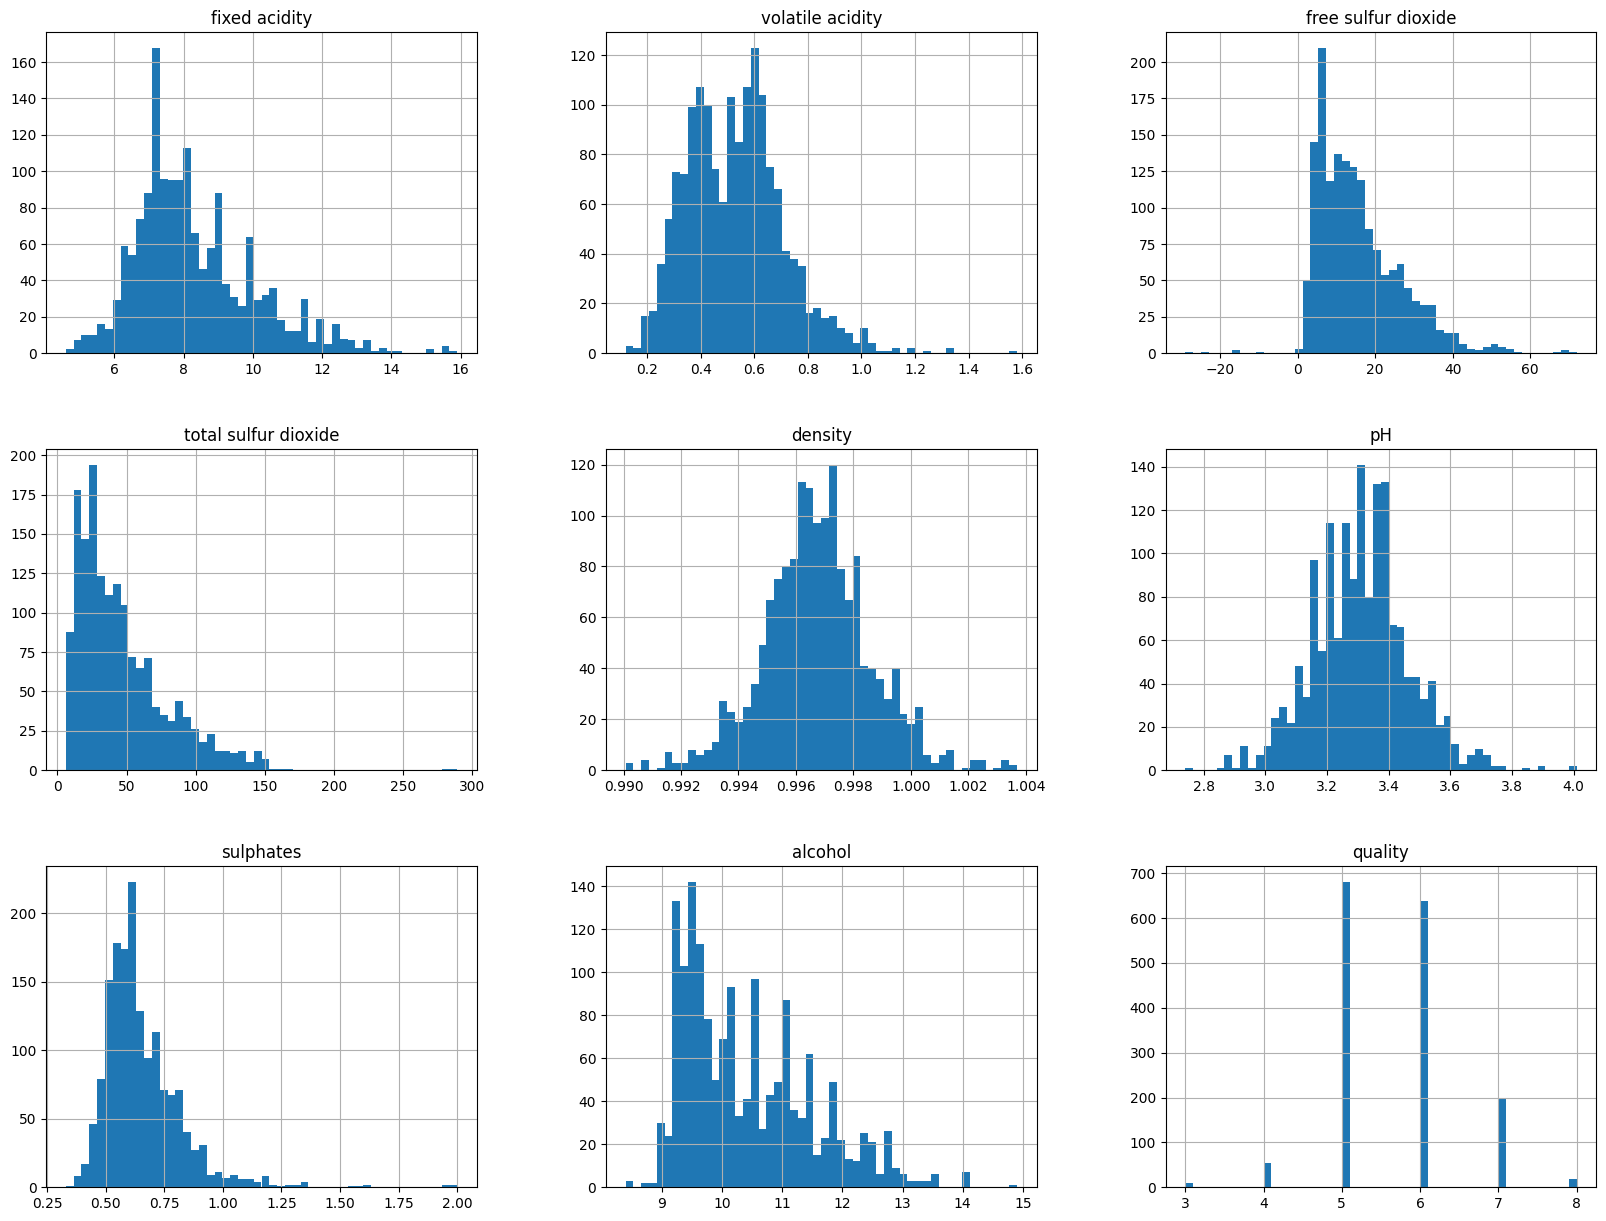

In [3]:
# Narysowanie histogramów dla wszystkich zmiennych oraz kilku innych przydatnych wykresów
wineDataFrame.hist(bins=50, figsize=(20,15))
plt.show()

# Czyszczenie danych

In [4]:
# usuń zbędne znaki (nie będące Ascii)
for column in wineDataFrame.columns:
    wineDataFrame[column] = wineDataFrame[column].astype(str).str.replace(r'[^\x00-\x7F]+', '', regex=True)
# zmien typ zmiennych ilościowych
for column in wineDataFrame.columns:
    wineDataFrame[column] = pd.to_numeric(wineDataFrame[column], errors='coerce')
# Wyświetlenie podstawowych informacji o zbiorze danych
print(wineDataFrame.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1596 non-null   float64
 3   residual sugar        1598 non-null   float64
 4   chlorides             1596 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1595 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


In [5]:
# Usuń wiersze z duplikatami
wineDataFrame.drop_duplicates(inplace=True)

choice = input("Wpisz 1 aby usunąć wiersze z brakującymi wartościami albo 2 aby uzupełnić je medianą: ")

if choice == '1':
    # Usuń wiersze z brakującymi danymi
    wineDataFrame.dropna(inplace=True)
elif choice == '2':
    # Uzupełnij brakujące dane medianą
    wineDataFrame.fillna(wineDataFrame.median(), inplace=True)
else:
    print("Niepoprawny wybór")

# Display basic information about the data set
print(wineDataFrame.info())
print(wineDataFrame.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 1352 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1352 non-null   float64
 1   volatile acidity      1352 non-null   float64
 2   citric acid           1352 non-null   float64
 3   residual sugar        1352 non-null   float64
 4   chlorides             1352 non-null   float64
 5   free sulfur dioxide   1352 non-null   float64
 6   total sulfur dioxide  1352 non-null   float64
 7   density               1352 non-null   float64
 8   pH                    1352 non-null   float64
 9   sulphates             1352 non-null   float64
 10  alcohol               1352 non-null   float64
 11  quality               1352 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 137.3 KB
None
(1352, 12)


In [6]:
# print empty values
print(wineDataFrame.isnull().sum())
# uzupełnij braki średnią
for column in wineDataFrame.columns:
    if wineDataFrame[column].isnull().sum() > 0:
        wineDataFrame[column] = wineDataFrame[column].fillna(method='pad')

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [7]:
# usunięcie rekorów z wartościami wyraźnie odstającymi
for column in wineDataFrame.columns:
    if column != 'quality' and pd.api.types.is_numeric_dtype(wineDataFrame[column]):
        Q1 = wineDataFrame[column].quantile(0.1)
        Q3 = wineDataFrame[column].quantile(0.90)
        IQR = Q3 - Q1

        filter = (wineDataFrame[column] >= Q1 - 1.5 * IQR) & (wineDataFrame[column] <= Q3 + 1.5 * IQR)
        wineDataFrame = wineDataFrame.loc[filter]

# Display basic information about the data set
print(wineDataFrame.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1269 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1269 non-null   float64
 1   volatile acidity      1269 non-null   float64
 2   citric acid           1269 non-null   float64
 3   residual sugar        1269 non-null   float64
 4   chlorides             1269 non-null   float64
 5   free sulfur dioxide   1269 non-null   float64
 6   total sulfur dioxide  1269 non-null   float64
 7   density               1269 non-null   float64
 8   pH                    1269 non-null   float64
 9   sulphates             1269 non-null   float64
 10  alcohol               1269 non-null   float64
 11  quality               1269 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 128.9 KB
None


<class 'pandas.core.frame.DataFrame'>
Index: 1269 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1269 non-null   float64
 1   volatile acidity      1269 non-null   float64
 2   citric acid           1269 non-null   float64
 3   residual sugar        1269 non-null   float64
 4   chlorides             1269 non-null   float64
 5   free sulfur dioxide   1269 non-null   float64
 6   total sulfur dioxide  1269 non-null   float64
 7   density               1269 non-null   float64
 8   pH                    1269 non-null   float64
 9   sulphates             1269 non-null   float64
 10  alcohol               1269 non-null   float64
 11  quality               1269 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 128.9 KB
None


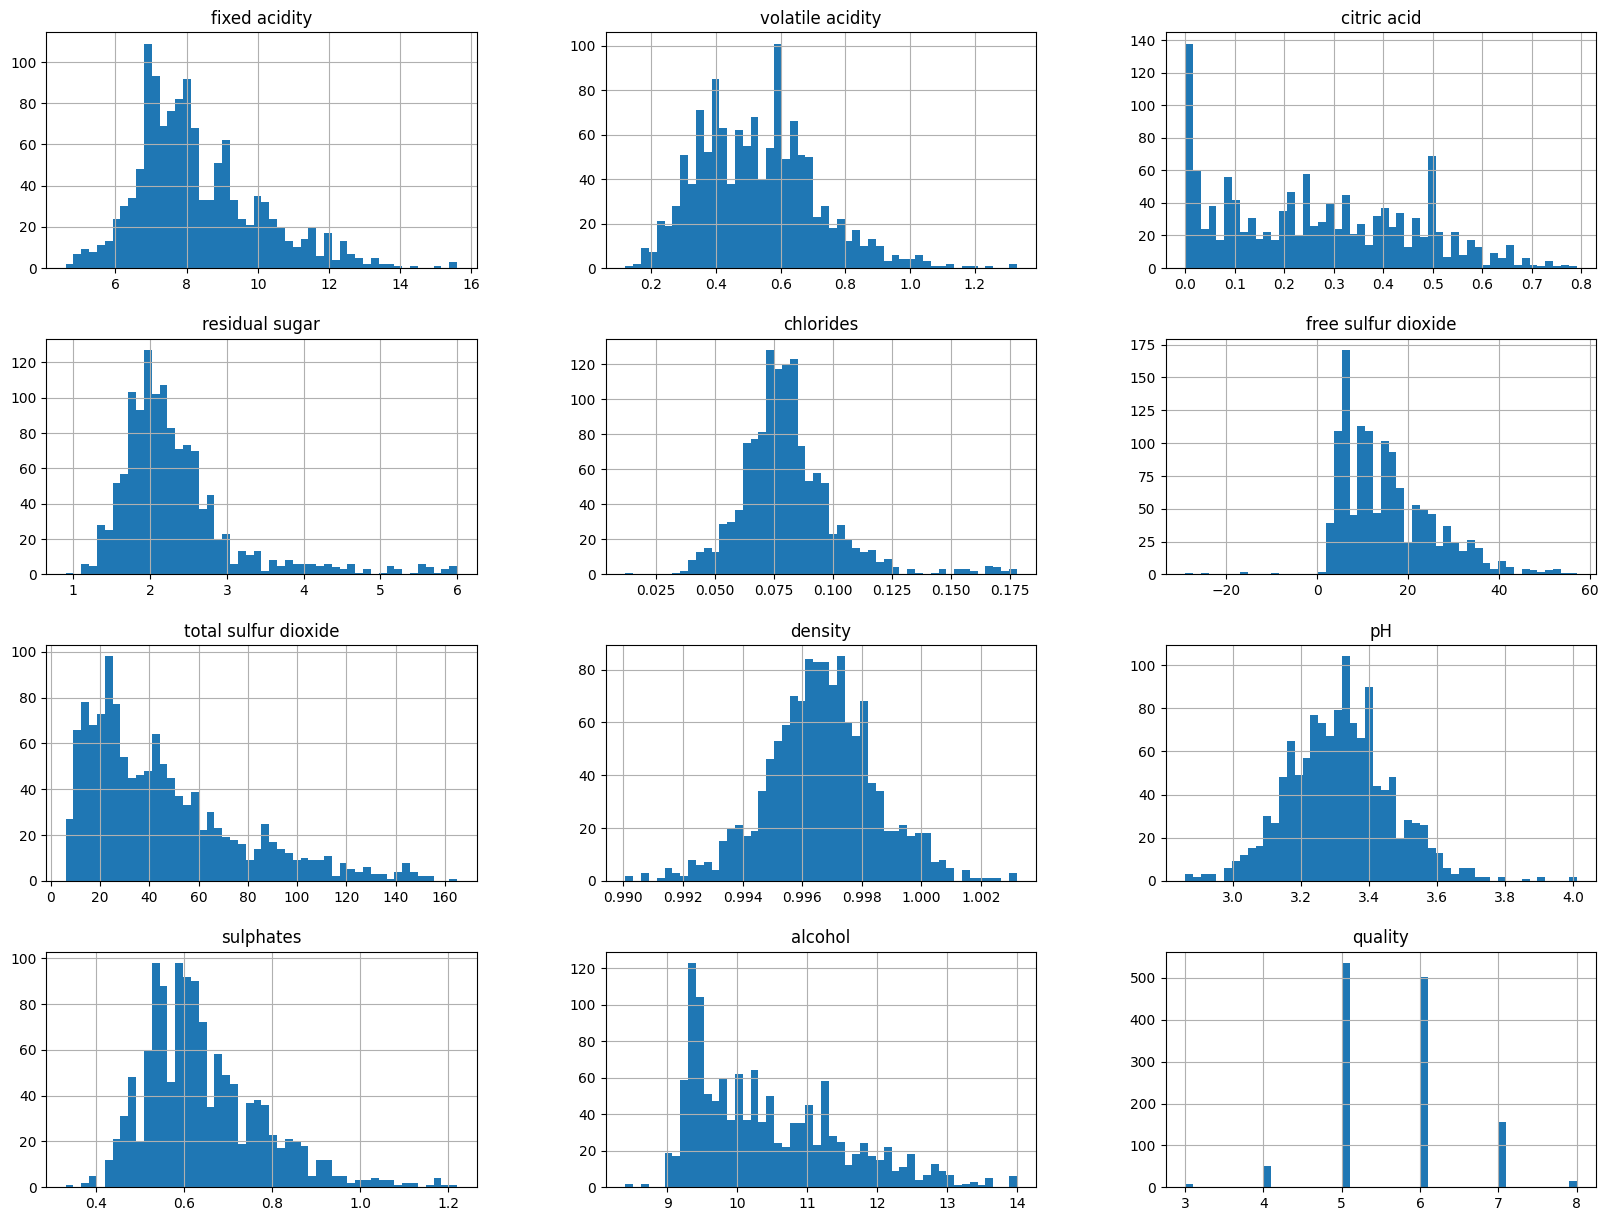

In [8]:
# Display basic information about the data set
print(wineDataFrame.info())
# plot histogram
wineDataFrame.hist(bins=50, figsize=(20,15))
plt.show()

In [9]:
# stwórz obiekt enkodera dla kolumn o typie obiektowym
le = LabelEncoder()
for column in wineDataFrame.columns:
    if pd.api.types.is_object_dtype(wineDataFrame[column]):
        wineDataFrame[column] = le.fit_transform(wineDataFrame[column])
# sprawdź transformacje
wineDataFrame.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5


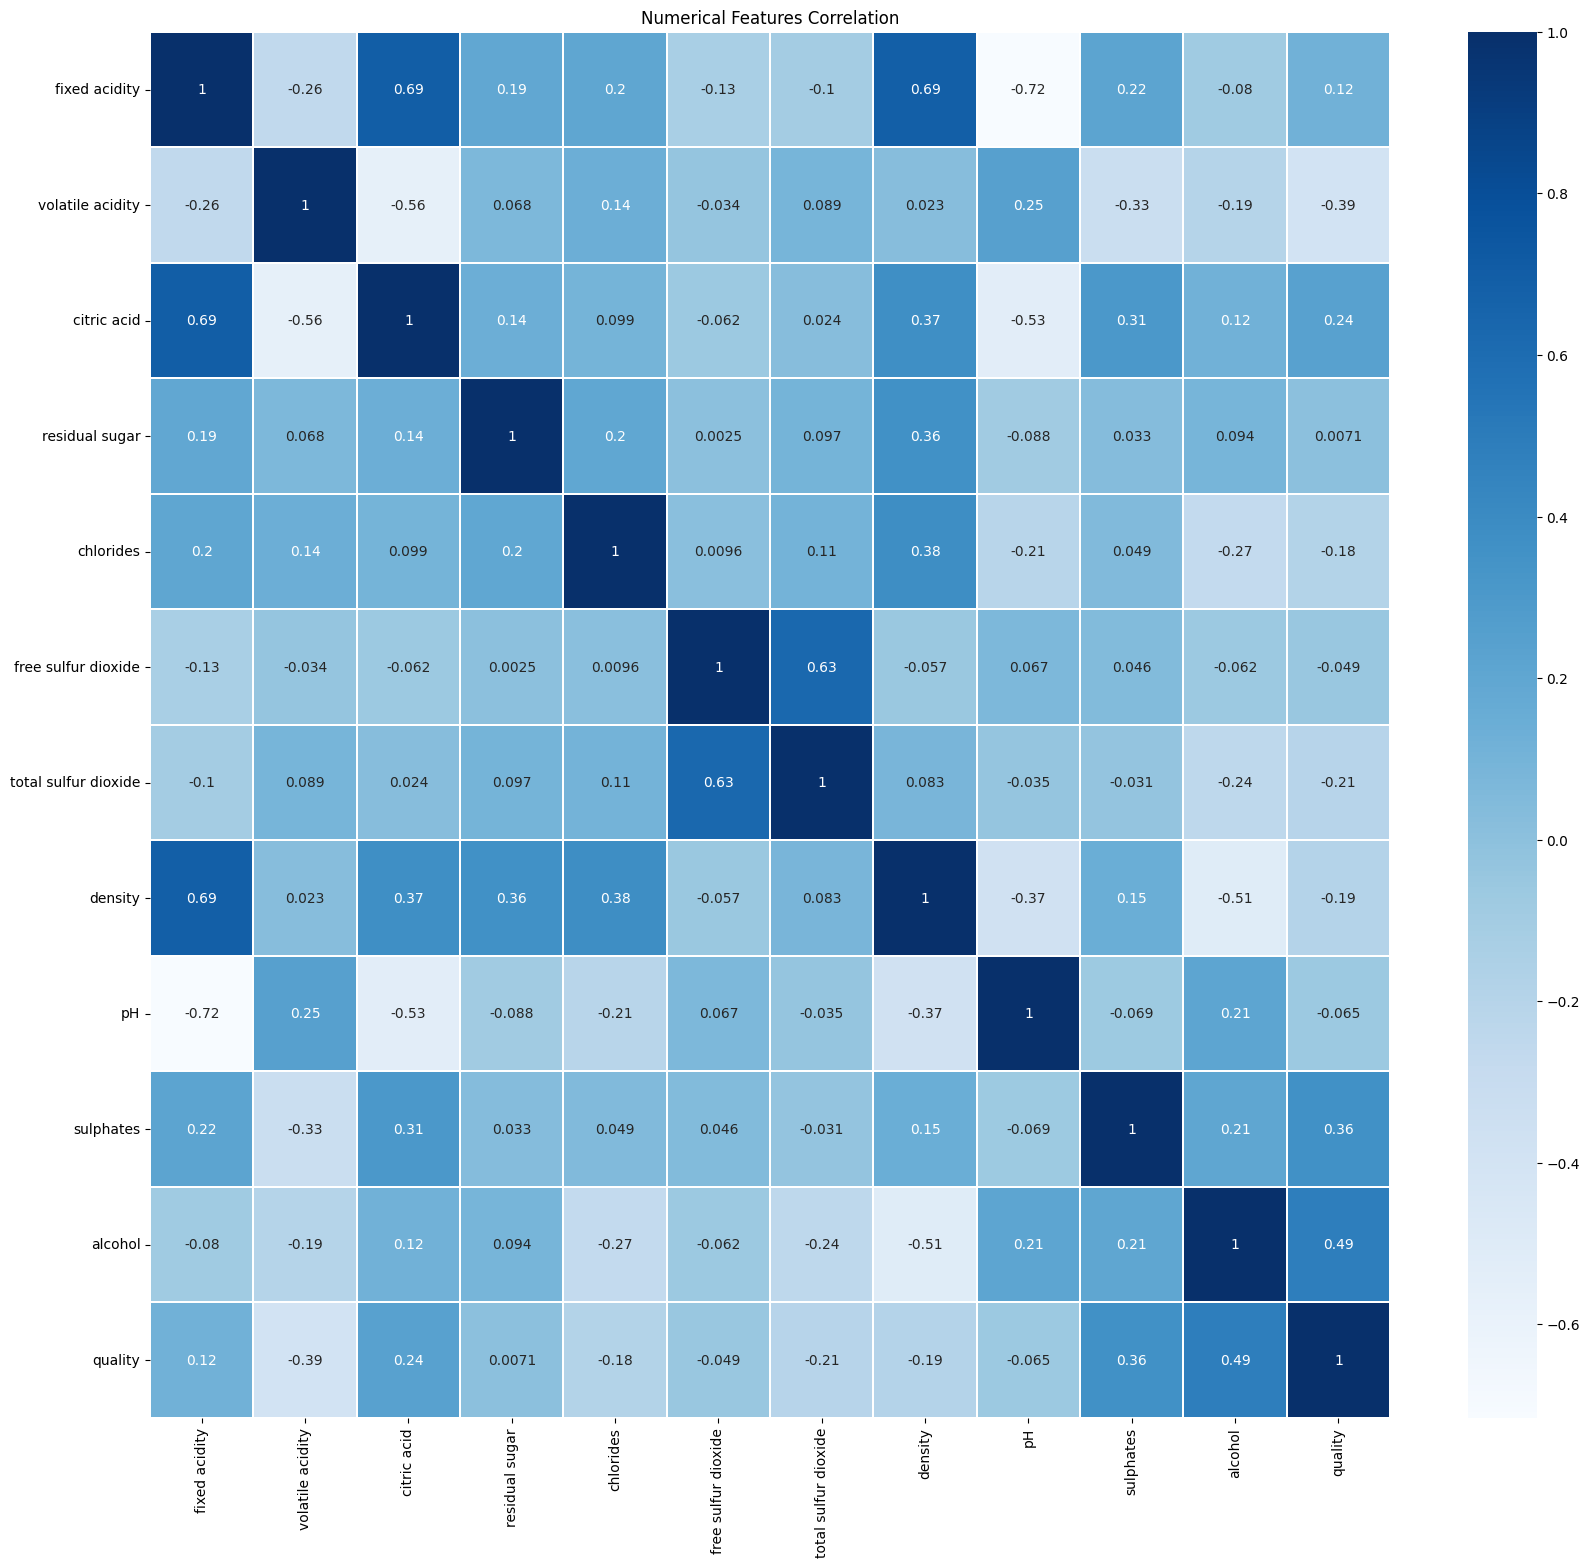

In [10]:
# wskaż korelacje
plt.figure(figsize = (20, 18)) 
# creating the correlation heatmap
sns.heatmap(wineDataFrame.corr(), annot = True, linewidths = 0.1, cmap = 'Blues')
plt.title('Numerical Features Correlation')
plt.show()

In [11]:
corr_matrix = wineDataFrame.corr()
cor_target = abs(corr_matrix["quality"])
relevant_features = cor_target[cor_target>0.1]

# print which features are relevant
print("Relevant features (correlation with 'quality' > 0.1):\n", relevant_features)

# and which are not
print("\nNon-relevant features (correlation with 'quality' <= 0.1):\n", cor_target[cor_target<=0.1])

wineDataFrame = wineDataFrame[relevant_features.index]

Relevant features (correlation with 'quality' > 0.1):
 fixed acidity           0.117542
volatile acidity        0.388561
citric acid             0.238599
chlorides               0.184223
total sulfur dioxide    0.205198
density                 0.189820
sulphates               0.359839
alcohol                 0.486402
quality                 1.000000
Name: quality, dtype: float64

Non-relevant features (correlation with 'quality' <= 0.1):
 residual sugar         0.007108
free sulfur dioxide    0.049403
pH                     0.065330
Name: quality, dtype: float64


In [12]:
wineDataFrame.head(5)

,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,alcohol,quality
0,7.4,0.70,0.00,0.076,34.0,0.9978,0.56,9.4,5
1,7.8,0.88,0.00,0.098,67.0,0.9968,0.68,9.8,5
2,7.8,0.76,0.04,0.092,54.0,0.9970,0.65,9.8,5
3,11.2,0.28,0.56,0.075,60.0,0.9980,0.58,9.8,6
5,7.4,0.66,0.00,0.075,40.0,0.9978,0.56,9.4,5


# Podział danych na zbiory treningowe i testowe

In [13]:
# Podziel dane na zbiór uczący i testowy
X = wineDataFrame.drop(columns=["quality"])
y = wineDataFrame["quality"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Rozmiar zbioru treningowego:", len(X_train))
print("Rozmiar zbioru testowego:", len(X_test))

Rozmiar zbioru treningowego: 888
Rozmiar zbioru testowego: 381


In [14]:
# Display the data splits
print("Training data (features):")
print(X_train.head())
print("\nTest data (features):")
print(X_test.head())
print("\nTraining data (target):")
print(y_train.head())
print("\nTest data (target):")
print(y_test.head())

Training data (features):
      fixed acidity  volatile acidity  citric acid  chlorides  \
1102            6.1              0.48         0.09      0.078   
1142            6.9              0.45         0.11      0.043   
1007            9.1              0.30         0.34      0.064   
1375            7.2              0.56         0.26      0.083   
1026            7.9              0.31         0.32      0.066   

      total sulfur dioxide  density  sulphates  alcohol  
1102                  30.0  0.99402       0.54     11.2  
1142                  12.0  0.99354       0.65     11.4  
1007                  25.0  0.99516       0.84     11.7  
1375                 100.0  0.99586       0.52      9.9  
1026                  36.0  0.99364       0.56     12.6  

Test data (features):
      fixed acidity  volatile acidity  citric acid  chlorides  \
1527            7.1              0.53         0.07      0.071   
1014            8.0              0.58         0.16      0.120   
530             9